In [1]:
import numpy as np
import pandas as pd
import difflib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
# loading the data from the csv file to apandas dataframe
movies_data = pd.read_csv(r'C:\Users\vishw\OneDrive\Documents\movies_metadata.csv',low_memory=False)
movies_data.drop_duplicates(subset='title',inplace=True)

In [3]:
# printing the first 5 rows of the dataframe
for column in movies_data.columns:
  movies_data[column] = movies_data[column].fillna('')
movies_data.head()


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,,Toy Story,False,7.7,5415.0
1,False,,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [4]:
# number of rows and columns in the data frame
movies_data.shape

(42278, 24)

In [5]:
# Function which converts strings to lists of dictionaries
import ast
def str_to_list_of_dicts(x):
    if isinstance(x, str):  #isinstance() checks that type of x is str or not
        
        # Convert string to actual list
        list_of_dicts = ast.literal_eval(x)
        # Ensure it's a list
        if isinstance(list_of_dicts, list):
            return list_of_dicts
    elif isinstance(x, list):
        return x
    return []

     
# Apply the evaluation function to convert strings to lists of dictionaries
movies_data['genres'] = movies_data['genres'].apply(str_to_list_of_dicts)

# Function to extract 'name' values from a list of dictionaries

def extract_names(list_of_dicts):
    return [d['name'] for d in list_of_dicts if type(d) and 'name' in d]

# Apply the function to extract 'name' values
movies_data['genres'] = movies_data['genres'].apply(extract_names)
movies_data['genres']=movies_data['genres'].apply(''.join)
print(movies_data['genres'])

0         AnimationComedyFamily
1        AdventureFantasyFamily
2                 RomanceComedy
3            ComedyDramaRomance
4                        Comedy
                  ...          
45459           Science Fiction
45461               DramaFamily
45462                     Drama
45464                          
45465                          
Name: genres, Length: 42278, dtype: object


In [6]:
# selecting the relevant features for recommendation
selected_features = ['genres','tagline','overview']
print(selected_features)

['genres', 'tagline', 'overview']


In [7]:
# replacing the null valuess with null string

for feature in selected_features:
  movies_data[feature] = movies_data[feature].fillna('')

In [8]:
movies_data['combined_features'] = movies_data['genres']+' '+movies_data['tagline']+' '+movies_data['overview']#+' '+movies_data['production_companies']
print( movies_data)

       adult                              belongs_to_collection    budget  \
0      False  {'id': 10194, 'name': 'Toy Story Collection', ...  30000000   
1      False                                                     65000000   
2      False  {'id': 119050, 'name': 'Grumpy Old Men Collect...         0   
3      False                                                     16000000   
4      False  {'id': 96871, 'name': 'Father of the Bride Col...         0   
...      ...                                                ...       ...   
45459  False                                                            0   
45461  False                                                            0   
45462  False                                                            0   
45464  False                                                            0   
45465  False                                                            0   

                       genres                              homepage      id

In [9]:
import nltk 

nltk.download('punkt') 
nltk.download('averaged_perceptron_tagger') 
nltk.download('wordnet') 


from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer() #Reduces words to their base form

from nltk.corpus import stopwords 
nltk.download('stopwords') # stopwords are words like "the","a","is" which are not useful and hence removed in text processing
stop_words = set(stopwords.words('english')) 

VERB_CODES = {'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'} # These are tags for various forms of verbs(like present , past participle)


def preprocess_sentences(text): 
    text = text.lower()     # Converts input text to lowercase
    temp_sent =[] 
    words = nltk.word_tokenize(text) # Tokenises text into words
    tags = nltk.pos_tag(words) # Tags each word with its part of speech
	
    # Basically we are lemmatizing

    for i, word in enumerate(words): 
	    if tags[i][1] in VERB_CODES: 
		    lemmatized = lemmatizer.lemmatize(word, 'v') 
	    else: 
		    lemmatized = lemmatizer.lemmatize(word) 
	    if lemmatized not in stop_words and lemmatized.isalpha(): 
		    temp_sent.append(lemmatized) 
		
    # We are joing processed words into string. 

    finalsent = ' '.join(temp_sent) 
	
    #replace function basically replaces those contracted words in the left to the words in the right
    finalsent = finalsent.replace("n't", " not") 
    finalsent = finalsent.replace("'m", " am") 
    finalsent = finalsent.replace("'s", " is") 
    finalsent = finalsent.replace("'re", " are") 
    finalsent = finalsent.replace("'ll", " will") 
    finalsent = finalsent.replace("'ve", " have") 
    finalsent = finalsent.replace("'d", " would") 
    return finalsent 

# Now we are applying this to preprocess tags

movies_data['combined_features']= movies_data['combined_features'].apply(preprocess_sentences) 
print(movies_data.head())

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vishw\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\vishw\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\vishw\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vishw\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


   adult                              belongs_to_collection    budget  \
0  False  {'id': 10194, 'name': 'Toy Story Collection', ...  30000000   
1  False                                                     65000000   
2  False  {'id': 119050, 'name': 'Grumpy Old Men Collect...         0   
3  False                                                     16000000   
4  False  {'id': 96871, 'name': 'Father of the Bride Col...         0   

                   genres                              homepage     id  \
0   AnimationComedyFamily  http://toystory.disney.com/toy-story    862   
1  AdventureFantasyFamily                                         8844   
2           RomanceComedy                                        15602   
3      ComedyDramaRomance                                        31357   
4                  Comedy                                        11862   

     imdb_id original_language               original_title  \
0  tt0114709                en                    Toy

In [10]:
df=movies_data[['id','title','combined_features']]


In [11]:
# converting the text data to feature vectors

# vectorizer = TfidfVectorizer()

In [12]:
# feature_vectors = vectorizer.fit_transform(combined_features)

In [13]:
from sklearn.feature_extraction.text import HashingVectorizer

hashing_vectorizer = HashingVectorizer(n_features=2**12,alternate_sign=False)  
feature_vectors = hashing_vectorizer.fit_transform(movies_data['combined_features'])


In [14]:
print(feature_vectors)

  (0, 242)	0.1386750490563073
  (0, 512)	0.1386750490563073
  (0, 754)	0.1386750490563073
  (0, 838)	0.1386750490563073
  (0, 1002)	0.1386750490563073
  (0, 1005)	0.1386750490563073
  (0, 1067)	0.1386750490563073
  (0, 1068)	0.1386750490563073
  (0, 1218)	0.1386750490563073
  (0, 1281)	0.1386750490563073
  (0, 1473)	0.1386750490563073
  (0, 1557)	0.41602514716892186
  (0, 1654)	0.1386750490563073
  (0, 1954)	0.41602514716892186
  (0, 2332)	0.1386750490563073
  (0, 2352)	0.1386750490563073
  (0, 2404)	0.1386750490563073
  (0, 2407)	0.1386750490563073
  (0, 2660)	0.41602514716892186
  (0, 2891)	0.1386750490563073
  (0, 3203)	0.1386750490563073
  (0, 3376)	0.1386750490563073
  (0, 3419)	0.1386750490563073
  (0, 3737)	0.1386750490563073
  (0, 3837)	0.1386750490563073
  :	:
  (42276, 3756)	0.09534625892455924
  (42276, 3910)	0.09534625892455924
  (42276, 3982)	0.09534625892455924
  (42276, 4008)	0.09534625892455924
  (42276, 4035)	0.09534625892455924
  (42277, 304)	0.22360679774997896
  (42

In [15]:
# getting the similarity scores using cosine similarity
similarity = cosine_similarity(feature_vectors,feature_vectors)

# from sklearn.feature_extraction.text import HashingVectorizer
# from sklearn.metrics.pairwise import cosine_similarity
# from scipy.sparse import lil_matrix
# import numpy as np

# # Assuming text_data is a list of strings
# vectorizer = HashingVectorizer(n_features=1000, norm=None)
# feature_vectors_sparse = vectorizer.fit_transform(movies_data['combined_features'])

# # Define batch size
# batch_size = 100

# # Calculate number of batches
# num_samples = feature_vectors_sparse.shape[0]
# num_batches = num_samples // batch_size + 1

# # Initialize an empty similarity matrix (sparse format, lil_matrix)
# similarity_sparse = lil_matrix((num_samples, num_samples), dtype=np.float64)

# # Calculate similarity in batches
# for i in range(num_batches):
#     start_idx = i * batch_size
#     end_idx = min((i + 1) * batch_size, num_samples)
#     batch_similarity = cosine_similarity(feature_vectors_sparse[start_idx:end_idx], feature_vectors_sparse)
#     similarity_sparse[start_idx:end_idx] = batch_similarity

# # Convert lil_matrix to csr_matrix for efficient operations
# similarity_sparse = similarity_sparse.tocsr()

# Now similarity_sparse is the sparse cosine similarity matrix


In [ ]:


# from sklearn.feature_extraction.text import HashingVectorizer
# import faiss

# # Initialize the HashingVectorizer
# hash_vectorizer = HashingVectorizer(n_features=2**12, alternate_sign=False)

# # Vectorize the plot_processed column
# tfidf_matrix = hash_vectorizer.transform(df["combined_features"])

# # Convert the sparse matrix to a dense format
# tfidf_dense = tfidf_matrix.toarray().astype(np.float32)

# # Normalize the vectors (Faiss requires this for cosine similarity)
# faiss.normalize_L2(tfidf_dense)

# # Create a Faiss index
# d = tfidf_dense.shape[1]  # dimension
# index = faiss.IndexFlatIP(d)  # inner product (dot product)
# index.add(tfidf_dense)  # add vectors to the index



In [16]:
print(similarity.shape)

(42278, 42278)


In [20]:
# getting the movie name from the user

movie_name = input(' Enter your favourite movie name : ')

 Enter your favourite movie name :  iron man 2


In [21]:
# creating a list with all the movie names given in the dataset

list_of_all_titles = movies_data['title'].tolist()
print(list_of_all_titles)

['Toy Story', 'Jumanji', 'Grumpier Old Men', 'Waiting to Exhale', 'Father of the Bride Part II', 'Heat', 'Sabrina', 'Tom and Huck', 'Sudden Death', 'GoldenEye', 'The American President', 'Dracula: Dead and Loving It', 'Balto', 'Nixon', 'Cutthroat Island', 'Casino', 'Sense and Sensibility', 'Four Rooms', 'Ace Ventura: When Nature Calls', 'Money Train', 'Get Shorty', 'Copycat', 'Assassins', 'Powder', 'Leaving Las Vegas', 'Othello', 'Now and Then', 'Persuasion', 'The City of Lost Children', 'Shanghai Triad', 'Dangerous Minds', 'Twelve Monkeys', 'Wings of Courage', 'Babe', 'Carrington', 'Dead Man Walking', 'Across the Sea of Time', 'It Takes Two', 'Clueless', 'Cry, the Beloved Country', 'Richard III', 'Dead Presidents', 'Restoration', 'Mortal Kombat', 'To Die For', 'How To Make An American Quilt', 'Se7en', 'Pocahontas', 'When Night Is Falling', 'The Usual Suspects', 'Guardian Angel', 'Mighty Aphrodite', 'Lamerica', 'The Big Green', 'Georgia', 'Kids of the Round Table', 'Home for the Holida

In [22]:
# finding the close match for the movie name given by the user

# find_close_match = difflib.get_close_matches(movie_name, list_of_all_titles)
# print(find_close_match)
import difflib

# Convert movie_name to string if it's a float
movie_name = str(movie_name)

# Convert all titles in list_of_all_titles to strings
list_of_all_titles = [str(title) for title in list_of_all_titles]

# Finding the close match for the movie name given by the user
# Adjusting the cutoff value to 0.5
find_close_match = difflib.get_close_matches(movie_name, list_of_all_titles, cutoff=0.6)

# find_close_match = difflib.get_close_matches(movie_name, list_of_all_titles)
print(find_close_match)


['Iron Man 2', 'Iron Man 3', 'Iron Man']


In [23]:
# def get_top_n_similar_movies(title, top_n=5):
#     # Find the index of the movie
#     movie_index = df[df['title'] == title].index[0]
#     # Find similar movie indices
#     query_vector = np.array([tfidf_dense[movie_index]])
#     distances, indices = index.search(query_vector, top_n)
#     # Return the titles of similar movies
#     return df.iloc[indices[0]]['title'].tolist()

# input_title = 'Iron Man'
# top_similar_movies = get_top_n_similar_movies(input_title, 5)
# print(f"Top similar movies to {input_title}: {top_similar_movies}")

In [24]:
close_match = find_close_match[0]
print(close_match)

Iron Man 2


In [25]:
# index_of_the_movie = movies_data[movies_data.title == close_match]['index'].values[0]
# print(index_of_the_movie)
close_match = find_close_match[0]  # Assuming find_close_match contains the closest match
index_of_the_movie = movies_data[movies_data['title'] == close_match].index[0]
print(index_of_the_movie)


15153


In [26]:
similarity_score = list(enumerate(similarity[index_of_the_movie]))
print(similarity_score)
# similarity_scores = cosine_sim_sparse[index_of_the_movie]
# print(similarity_scores)
# Iterate over each score and compare it to the threshold
# Convert similarity_scores to a numpy array
# similarity_scores = cosine_sim_sparse.getrow(index_of_the_movie).toarray()[0]

# # Print the similarity scores
# print(similarity_scores)

[(0, 0.0), (1, 0.0), (2, 0.0), (3, 0.0), (4, 0.08219949365267866), (5, 0.025367314471592052), (6, 0.0), (7, 0.04175738453296618), (8, 0.02087869226648309), (9, 0.035049981861639094), (10, 0.0), (11, 0.0), (12, 0.0), (13, 0.10810810810810818), (14, 0.04604092555161307), (15, 0.0), (16, 0.0), (17, 0.0), (18, 0.0), (19, 0.0), (20, 0.04047223292581766), (21, 0.0), (22, 0.0), (23, 0.02632490632463282), (24, 0.03427955850955306), (25, 0.11624763874381931), (26, 0.0), (27, 0.04142465106674669), (28, 0.0), (29, 0.0), (30, 0.0), (31, 0.0), (32, 0.0), (33, 0.019649437297296495), (34, 0.0), (35, 0.0), (36, 0.017727598712973545), (37, 0.0), (38, 0.0), (39, 0.0), (40, 0.05198752449100365), (41, 0.05198752449100365), (42, 0.0), (43, 0.02423930827818599), (44, 0.061056251087266374), (45, 0.04109974682633933), (46, 0.04078236951430927), (47, 0.021586644588817275), (48, 0.0), (49, 0.06974858324629157), (50, 0.0), (51, 0.04604092555161308), (52, 0.0), (53, 0.0), (54, 0.0), (55, 0.0), (56, 0.0), (57, 0.0

In [27]:
len(similarity_score)


42278

In [28]:
sorted_similar_movies = sorted(similarity_score, key = lambda x:x[1], reverse = True) 
print(sorted_similar_movies)
# sorted_similar_movies = sorted(enumerate(similarity_scores), key=lambda x: x[1], reverse=True)
# print(sorted_similar_movies)



[(15153, 1.0000000000000007), (29423, 0.3487429162314579), (634, 0.32879797461071464), (635, 0.32879797461071464), (641, 0.32879797461071464), (1407, 0.32879797461071464), (4700, 0.32879797461071464), (5867, 0.32879797461071464), (12498, 0.32879797461071464), (13097, 0.32879797461071464), (13180, 0.32879797461071464), (13186, 0.32879797461071464), (13237, 0.32879797461071464), (13623, 0.32879797461071464), (14127, 0.32879797461071464), (14320, 0.32879797461071464), (16479, 0.32879797461071464), (16637, 0.32879797461071464), (16869, 0.32879797461071464), (17610, 0.32879797461071464), (18942, 0.32879797461071464), (19013, 0.32879797461071464), (19236, 0.32879797461071464), (19237, 0.32879797461071464), (20155, 0.32879797461071464), (20201, 0.32879797461071464), (20712, 0.32879797461071464), (21453, 0.32879797461071464), (21476, 0.32879797461071464), (21487, 0.32879797461071464), (21623, 0.32879797461071464), (21648, 0.32879797461071464), (21734, 0.32879797461071464), (21844, 0.3287979746

In [29]:
# print the name of similar movies based on the index

print('Movies suggested for you : \n')

i = 1

for movie in sorted_similar_movies:
  index = movie[0]
  title_from_index = movies_data[movies_data.index==index]['title'].values[0]
  if (i<30):
    print(i, '.',title_from_index)
    i+=1
# print('Movies suggested for you: \n')

# sorted_similar_movies = sorted(sorted_similar_movies, key=lambda x: x[1], reverse=True)  # Sort by similarity scores in descending order

# i = 1

# for movie in sorted_similar_movies:
#     index = movie[0]
#     title_from_index = movies_data.iloc[index]['title']  # Access 'title' column directly
#     if title_from_index:  # Check if the movie name is not empty
#         print(title_from_index)
#         i += 1
#     if i >= 30:  # Stop printing after 30 movies
#         break




Movies suggested for you : 

1 . Iron Man 2
2 . Zandy's Bride
3 . Peanuts – Die Bank zahlt alles
4 . Happy Weekend
5 . The Superwife
6 . Lost Highway
7 . Brubaker
8 . Blue Collar Comedy Tour: The Movie
9 . Tropical Malady
10 . Soul Men
11 . Nothing Like the Holidays
12 . The Forgotten One
13 . Alien Raiders
14 . Komedia malzenska
15 . The Handcuff King
16 . The Sound Barrier
17 . The Spy in Black
18 . Mysterious Object at Noon


IndexError: index 0 is out of bounds for axis 0 with size 0

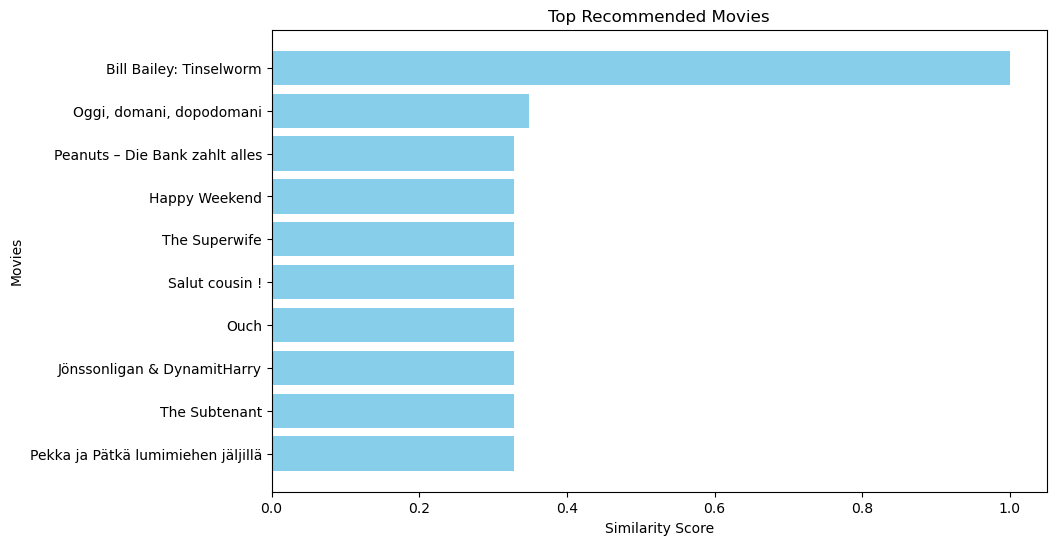

In [30]:
import matplotlib.pyplot as plt

# Extract movie titles and similarity scores from sorted_similar_movies
top_movies = [movies_data.iloc[movie[0]]['title'] for movie in sorted_similar_movies[:10]]
similarity_scores = [movie[1] for movie in sorted_similar_movies[:10]]

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(top_movies, similarity_scores, color='skyblue')
plt.xlabel('Similarity Score')
plt.ylabel('Movies')
plt.title('Top Recommended Movies')
plt.gca().invert_yaxis()  # Invert y-axis to have highest similarity at the top
plt.show()


## Collaborative filtering for movie recommendations

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.neighbors import NearestNeighbors
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [61]:
#loading rating dataset
ratings=pd.read_csv(r'C:\Users\vishw\OneDrive\Documents\ratings.csv')
ratings=ratings.fillna(0)
ratings

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556
...,...,...,...,...
26024284,270896,58559,5.0,1257031564
26024285,270896,60069,5.0,1257032032
26024286,270896,63082,4.5,1257031764
26024287,270896,64957,4.5,1257033990


In [62]:
print(ratings.columns)

Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')


In [63]:
#loading movies dataset
movies = pd.read_csv(r'C:\Users\vishw\OneDrive\Documents\movies_metadata.csv',low_memory=False)
print(movies.head())
movies['id']=pd.to_numeric(movies['id'],errors='coerce')

   adult                              belongs_to_collection    budget  \
0  False  {'id': 10194, 'name': 'Toy Story Collection', ...  30000000   
1  False                                                NaN  65000000   
2  False  {'id': 119050, 'name': 'Grumpy Old Men Collect...         0   
3  False                                                NaN  16000000   
4  False  {'id': 96871, 'name': 'Father of the Bride Col...         0   

                                              genres  \
0  [{'id': 16, 'name': 'Animation'}, {'id': 35, '...   
1  [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...   
2  [{'id': 10749, 'name': 'Romance'}, {'id': 35, ...   
3  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...   
4                     [{'id': 35, 'name': 'Comedy'}]   

                               homepage     id    imdb_id original_language  \
0  http://toystory.disney.com/toy-story    862  tt0114709                en   
1                                   NaN   8844  tt0113497         

In [64]:
user_freq = ratings[['userId', 'movieId']].groupby(  #to print the frequency of ratings given by user
	'userId').count().reset_index()
user_freq.columns = ['userId', 'n_ratings']
print(user_freq.head())


   userId  n_ratings
0       1         27
1       2         22
2       3         10
3       4         62
4       5         26


In [65]:
# Now, we create user-item matrix using scipy csr matrix
from scipy.sparse import csr_matrix #CSR matrix is used in recommendation systems to represent the relationship between users and movies

def create_matrix(df):
	
	N = len(df['userId'].unique()) #no. of unique users
	M = len(df['movieId'].unique()) #no. of unique movies
	
	# Map movie and user Ids to indices
	user_mapper = dict(zip(np.unique(df["userId"]), list(range(N))))
	movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(M))))
	
	# Map indices to IDs
	user_inv_mapper = dict(zip(list(range(N)), np.unique(df["userId"])))
	movie_inv_mapper = dict(zip(list(range(M)), np.unique(df["movieId"])))
	
	user_index = [user_mapper[i] for i in df['userId']]
	movie_index = [movie_mapper[i] for i in df['movieId']]

	X = csr_matrix((df["rating"], (movie_index, user_index)), shape=(M, N))
	#The matrix is constructed such that X[i, j] is the rating given by user j to movie i.
	return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper
	
X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_matrix(ratings)


In [66]:
print(movies['id'].unique())
# Create the movie_titles dictionary directly from the 'id' and 'title' columns
movie_titles = dict(zip(movies['id'], movies['title']))

# Print the first few elements of the movie_titles dictionary
print("Movie Titles Dictionary (first 10 entries):")
for i, (k, v) in enumerate(movie_titles.items()):
    print(k, v)
    if i >= 9:
        break
# Check the data type of keys in the movie_titles dictionary
print("Data type of keys in movie_titles dictionary:", type(list(movie_titles.keys())[0]))

# Check if the movie ID 8844 exists in the dictionary
print("Does movie ID 8844 exist in the dictionary?", 8844 in movie_titles)


[   862.   8844.  15602. ...  67758. 227506. 461257.]
Movie Titles Dictionary (first 10 entries):
862.0 Toy Story
8844.0 Jumanji
15602.0 Grumpier Old Men
31357.0 Waiting to Exhale
11862.0 Father of the Bride Part II
949.0 Heat
11860.0 Sabrina
45325.0 Tom and Huck
9091.0 Sudden Death
710.0 GoldenEye
Data type of keys in movie_titles dictionary: <class 'float'>
Does movie ID 8844 exist in the dictionary? True


In [68]:
## Find similar movies using KNN
def find_similar_movies(movie_id, X, k, metric='cosine', show_distance=False):
	
	neighbour_ids = [] #to store the IDs of similar movies.
	
	movie_ind = movie_mapper[movie_id]
	movie_vec = X[movie_ind]
	k+=1
	kNN = NearestNeighbors(n_neighbors=k, algorithm="brute", metric=metric)
	kNN.fit(X)
	movie_vec = movie_vec.reshape(1,-1) #reshape to a 2D array
	neighbour = kNN.kneighbors(movie_vec, return_distance=show_distance)
	for i in range(0,k):
		n = neighbour.item(i)
		neighbour_ids.append(movie_inv_mapper[n])
	neighbour_ids.pop(0)
	return neighbour_ids


movie_titles = dict(zip(movies['id'], movies['title']))
movie_id =862

similar_ids = find_similar_movies(movie_id, X, k=20)
print(similar_ids)
movie_title = movie_titles.get(movie_id, None)  # Using get() method to handle missing keys
printed=0
if movie_title is None:
    print(f"Movie with ID {movie_id} not found.")
else:
    print(f"Since you watched {movie_title}")
    for i, similar_id in enumerate(similar_ids):
        if(printed==5):
            break
        movie_title = movie_titles.get(similar_id, None)  # Using get() method to handle missing keys
        if movie_title is not None:
            print(movie_title)
            printed+=1


[1392, 860, 877, 803, 630, 138, 55, 764, 1187, 80, 1443, 1399, 988, 1397, 523, 728, 869, 1041, 67, 1051]
Since you watched Toy Story
Born into Brothels
WarGames
Scarface
Night and Fog
The Wizard of Oz


In [69]:
# Movie Recommendation with respect to Users Preference
def recommend_movies_for_user(user_id, X, user_mapper, movie_mapper, movie_inv_mapper, k=10):
	df1 = ratings[ratings['userId'] == user_id] #The function filters the ratings DataFrame (ratings) to retrieve ratings made by the specified user_id and stores the result in df1.
	
	if df1.empty:
		print(f"User with ID {user_id} does not exist.")
		return

	movie_id = df1[df1['rating'] == max(df1['rating'])]['movieId'].iloc[0] #If the user has rated movies, the function identifies the movie with the highest rating among the user's ratings.

	movie_titles = dict(zip(movies['id'], movies['title']))

	similar_ids = find_similar_movies(movie_id, X, k) #he function calls the find_similar_movies function to find similar movies to the one with the highest rating by the user.
	movie_title = movie_titles.get(movie_id, "Movie not found")

	if movie_title == "Movie not found":
		print(f"Movie with ID {movie_id} not found.")
		return

	print(f"Since you watched {movie_title}, you might also like:")
	for i in similar_ids:
		print(movie_titles.get(i, "Movie not found"))


In [70]:
user_id = 862 # Replace with the desired user ID
recommend_movies_for_user(user_id, X, user_mapper, movie_mapper, movie_inv_mapper, k=10)


Since you watched The Million Dollar Hotel, you might also like:
Terminator 3: Rise of the Machines
Solaris
Movie not found
Once Were Warriors
Movie not found
Movie not found
Three Colors: Red
Movie not found
License to Wed
48 Hrs.


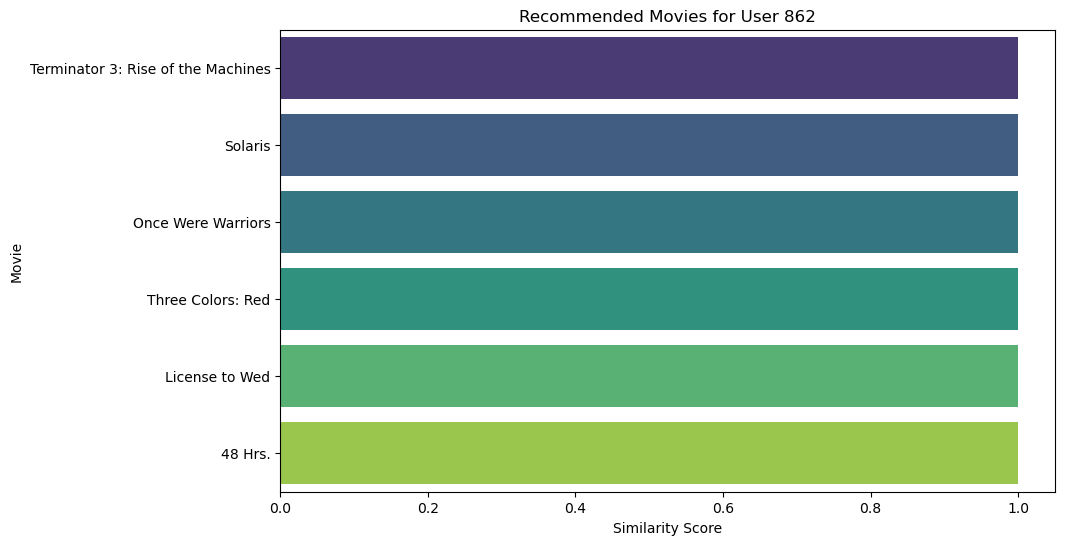

In [71]:
# Function to create visualization of recommended movies for a user
def visualize_recommendations(user_id, recommended_movies):
    plt.figure(figsize=(10, 6))
    sns.barplot(y='Movie', x='Similarity Score', data=recommended_movies, palette='viridis')
    plt.title(f'Recommended Movies for User {user_id}')
    plt.xlabel('Similarity Score')
    plt.ylabel('Movie')
    plt.show()

# Function to recommend movies for a user and visualize the recommendations
def recommend_and_visualize(user_id, X, user_mapper, movie_mapper, movie_inv_mapper, k=10):
    df1 = ratings[ratings['userId'] == user_id]
    if df1.empty:
        print(f"User with ID {user_id} does not exist.")
        return

    movie_id = df1[df1['rating'] == max(df1['rating'])]['movieId'].iloc[0]
    similar_ids = find_similar_movies(movie_id, X, k)
    movie_titles = dict(zip(movies['id'], movies['title']))

    recommended_movies = []
    for i in similar_ids:
        movie_title = movie_titles.get(i, "Movie not found")
        if movie_title != "Movie not found":
            recommended_movies.append({'Movie': movie_title, 'Similarity Score': 1})  # Assuming similarity score is 1 for simplicity

    if not recommended_movies:
        print("No recommendations found for the user.")
        return

    recommended_movies_df = pd.DataFrame(recommended_movies)
    visualize_recommendations(user_id, recommended_movies_df)

# Visualize recommendations for a specific user
user_id = 862  # Replace with the desired user ID
recommend_and_visualize(user_id, X, user_mapper, movie_mapper, movie_inv_mapper, k=10)


In [72]:
# from sklearn.metrics import precision_score, recall_score, f1_score

# # Function to evaluate model performance
# def evaluate_model(X, user_mapper, movie_mapper, movie_inv_mapper, ratings, k=10):
#     precision_scores = []
#     recall_scores = []
#     f1_scores = []

#     for user_id in ratings['userId'].unique():
#         df1 = ratings[ratings['userId'] == user_id]
#         if df1.empty:
#             continue

#         actual_movies = df1['movieId'].tolist()
        
#         # Choose a subset of movies that the user hasn't interacted with
#         user_interacted_movies = set(actual_movies)
#         movies_to_recommend = [movie_id for movie_id in movie_mapper.keys() if movie_id not in user_interacted_movies]
        
#         # Generate recommendations for the user
#         recommended_movies = []
#         for movie_id in movies_to_recommend:
#             similar_ids = find_similar_movies(movie_id, X, k)
#             for i in similar_ids:
#                 movie_title = movie_titles.get(i, "Movie not found")
#                 if movie_title != "Movie not found":
#                     recommended_movies.append(i)

#         # Truncate the recommended list to match the length of actual movies
#         recommended_movies = recommended_movies[:len(actual_movies)]
        
#         precision_scores.append(precision_score(actual_movies, recommended_movies, average='macro'))
#         recall_scores.append(recall_score(actual_movies, recommended_movies, average='macro'))
#         f1_scores.append(f1_score(actual_movies, recommended_movies, average='macro'))

#     # Calculate mean scores
#     mean_precision = np.mean(precision_scores)
#     mean_recall = np.mean(recall_scores)
#     mean_f1 = np.mean(f1_scores)

#     return mean_precision, mean_recall, mean_f1


# # Evaluate model performance
# precision, recall, f1 = evaluate_model(X, user_mapper, movie_mapper, movie_inv_mapper, ratings, k=10)
# print("Precision:", precision)
# print("Recall:", recall)
# print("F1-score:", f1)

# # Visualize model performance
# plt.figure(figsize=(8, 5))
# scores = [precision, recall, f1]
# metrics = ['Precision', 'Recall', 'F1-score']
# sns.barplot(x=metrics, y=scores, palette='viridis')
# plt.title('Model Performance Metrics')
# plt.ylabel('Score')
# plt.show()


In [75]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from scipy.sparse import csr_matrix



# Split the ratings dataset into training and testing sets
train_data, test_data = train_test_split(ratings, test_size=0.2, random_state=42)

# Create the user-item matrix X_train
X_train = csr_matrix((train_data['rating'], (train_data['movieId'], train_data['userId'])))

# Print the shape of X_train
print("Shape of X_train:", X_train.shape)

# Check if X_train has any non-zero elements
if X_train.getnnz() > 0:
    # Get the indices of non-zero elements
    train_indices = X_train.indices
    
    # Get the corresponding movieIds and userIds
    train_movie_ids = train_data['movieId'].iloc[train_indices]
    train_user_ids = train_data['userId'].iloc[train_indices]
    
    # Create a DataFrame with the indices, movieId, and userId
    train_df = pd.DataFrame({'index': train_indices, 'movieId': train_movie_ids, 'userId': train_user_ids})
    
    # Merge the train_data with train_df based on movieId and userId
    merged_train_data = pd.merge(train_data, train_df, on=['movieId', 'userId'])
    
    # Extract the filtered ratings and corresponding indices
    filtered_ratings = merged_train_data['rating']
    
    # Train the KNN model on the filtered training data
    knn_model = KNeighborsRegressor(n_neighbors=5, metric='cosine')
    knn_model.fit(X_train[merged_train_data['index']], filtered_ratings)
    
    # Create the user-item matrix X_test
    X_test = csr_matrix((test_data['rating'], (test_data['movieId'], test_data['userId'])))
    
    # Make predictions on the testing data
    predictions = knn_model.predict(X_test)
    
    # Evaluate the performance of the model using Mean Absolute Error (MAE)
    mae = mean_absolute_error(test_data['rating'], predictions)
    print("Mean Absolute Error (MAE):", mae)
else:
    print("X_train has no non-zero elements. Please check your data and preprocessing steps.")


Shape of X_train: (176276, 270897)


MemoryError: cannot allocate memory for array